In [291]:
# !pip install pandasai


In [292]:
import pandas as pd

In [293]:
df = pd.read_excel('Sample Data_Copilot.xlsx')

In [294]:
def get_csv_schema(df) -> str:
    """
    Generate schema details from the CSV.
    """
    # Fetching column names and their types
    schema_details = "The CSV contains the following columns:\n"
    # Iterating over the columns and their types
    for column in df.columns:
        dtype = df[column].dtype
        schema_details += f"- Column: *{column}*, Data Type: *{dtype}*\n"
        if dtype == object:
            schema_details += f"Unique Values: {df[column].unique()}"
    # Highlighting important columns (e.g., month columns and dimensions)
    month_columns = [
        col
        for col in df.columns
        if col
        in [
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ]
    ]
    dimension_columns = [col for col in df.columns if col not in month_columns]
    schema_details += "\n=== Special Columns ===\n"
    schema_details += f"Dimensions: {', '.join(dimension_columns)}\n"

    return schema_details

In [295]:
df_info = f"""
Columns and their types:
{df.dtypes.to_string()}

Sample data (first few rows):
{df.head().to_string()}
"""

In [296]:
schema = get_csv_schema(df)

In [297]:
import re
from dotenv import load_dotenv
from openai import AzureOpenAI
from langchain_openai import AzureChatOpenAI
import os 

def init_openai_client() -> AzureChatOpenAI:
    load_dotenv() 

    endpoint = os.getenv("AZURE_ENDPOINT")
    key = os.getenv("AZURE_API_KEY")
    api_version = os.getenv("AZURE_API_VERSION")
    azure_deployment = os.getenv("AZURE_DEPLOYMENT")
    # httpx_client = httpx.Client(http2=True, verify=False)

    return AzureChatOpenAI(
        api_key=key,
        api_version=api_version,
        azure_endpoint=endpoint,
        azure_deployment=azure_deployment,
        # http_client=httpx_client
    )

In [298]:
client = init_openai_client()

In [ ]:
# df_info = get_csv_schema(df)

df_info = f"""
Columns and their types:
{df.dtypes.to_string()}

Sample data (first few rows):
{df.head().to_string()}
"""
#query = "create a report to show spend by Country Short for Professional Services from PO_L1"
#query = "create visuals to show spend by PO_L1"
#query ="create a report to show spend by company code"
query = "create a report to show top cg_normalized_vendor by spend"
#query= "Create a report to show all cg_normalized_vendor with distinct payment terms"



human_msg = f"""
You are a data analyst assistant. You are given a DataFrame with the following structure:

{df_info}

Your task is to:
1. Write clean and reproducible Python code using pandas and matplotlib to answer the following question: *{query}*.
2. Assign the final result to a variable named `result_df`.
3. Generate a short, natural language summary of the result and assign it to a variable named `summary_text`.
4. Create a plot that visualizes the key insights and save it using `plt.savefig('top_vendors_plot.png')`. Adjust the plot size dynamically based on the number of data points.
5. Do not use random sampling or introduce variability in the output.
6. Ensure the code is deterministic and produces the same result every time it is run.

Output only the Python code in a single code block.
"""




In [300]:

# human_msg = (
#         f"\nThis is the Dataframe info : {df_info}. "
#         f"\nI need you to write a code for this question: *{query}*."
#         f"\nAlso, please do the following:"
#         f"\n1. Generate a short summary of the result and assign it to a variable named `summary_text` in natural language which will give some insights."
#         f"\n2. Create a plot to visualize the key insights and save it using `plt.savefig('top_vendors_plot.png')`. Also increase and decrease the plot size based on the values"
# )



In [301]:
print(human_msg)


You are a data analyst assistant. You are given a DataFrame with the following structure:


Columns and their types:
Cg_Normalized_Vendor                    object
PO_L1                                   object
PO_L2                                   object
PO_L3                                   object
PO_L4                                   object
G/L Acct Long Text                      object
Company Code                            object
Region                                  object
Document number                         object
Purchasing Document                     object
Posting Date                    datetime64[ns]
Payment terms                           object
Payment term No. of Days               float64
Payment term Own Explanation            object
Spend                                  float64

Sample data (first few rows):
  Cg_Normalized_Vendor                            PO_L1                            PO_L2                            PO_L3                         

In [302]:
# system_message = """ 
# You are a Python code generator. You will be given a pandas DataFrame and a question. 
# **Important Notes:**
#          * Always use `df` to refer to the current year's data.
#          * **Do not include any code to load the DataFrame.** They are already loaded and available in the environment.
#          * Your final Python code **must** have the resulting pandas DataFrame as the last variable in the code block. This DataFrame will be the output of your analysis.

#          **Output:**
#          Generate complete and executable pandas code that performs the requested data analysis on `df`. The code should handle necessary operations and ensure the final result is a pandas DataFrame.
# """
# messages = [
#     {"role": "human", "content": system_message},
#     {"role": "user", "content": human_msg }
# ]

# response = client.invoke(messages)




In [303]:
import pandas as pd 
import numpy as np

def extract_python_code(text):
    match = re.search(r"```python\n(.*?)\n```", text, re.DOTALL)
    return match.group(1) if match else "" 

def execute_pandas_code(code):
    import os

    local_vars = {"df": df}
    globals_dict = {
        "pd": pd,
        "np": np,
        "plt": __import__("matplotlib.pyplot"),
    }

    try:
        clean_code = extract_python_code(code)
        print("\n\nClean Code:\n", clean_code)
        exec(clean_code, globals_dict, local_vars)

        result_vars = [
            var for var in local_vars.keys()
            if isinstance(local_vars[var], pd.DataFrame)
        ]

        result_df = local_vars[result_vars[-1]] if result_vars else None

        # Extract summary if available
        summary_text = local_vars.get("summary_text", "No summary was generated.")

        # Detect plot file
        plot_file = None
        for file in os.listdir():
            if file.endswith(".png"):
                plot_file = file
                break

        if isinstance(result_df, pd.DataFrame) and not result_df.empty:
            return {
                "final_response": {
                    "is_pandas_code": True,
                    "pandas_code": clean_code,
                    "response_content": result_df,
                    "summary": summary_text,
                    "plot_path": plot_file,
                }
            }

        return {
            "final_response": {
                "is_pandas_code": False,
                "pandas_code": clean_code,
                "response_content": "Execution successful but returned no data.",
                "summary": summary_text,
                "plot_path": plot_file,
            }
        }

    except Exception as e:
        return {
            "final_response": {
                "is_pandas_code": False,
                "pandas_code": None,
                "response_content": f"An error occurred: {str(e)}",
                "summary": None,
                "plot_path": None,
            }
        }




Clean Code:
 import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is the DataFrame containing the data
# Grouping the data by 'Company Code' and summing the 'Spend'
result_df = df.groupby('Company Code')['Spend'].sum().reset_index()

# Sorting the results in descending order
result_df = result_df.sort_values(by='Spend', ascending=False)

# Generating a summary text
summary_text = f"The total spend by company code is summarized in the result DataFrame. " \
               f"The company with the highest spend is {result_df.iloc[0]['Company Code']} " \
               f"with a total spend of ${result_df.iloc[0]['Spend']:,.2f}."

# Creating a plot to visualize the spend by company code
plt.figure(figsize=(10, len(result_df) * 0.5))  # Adjusting size based on number of entries
plt.barh(result_df['Company Code'], result_df['Spend'], color='skyblue')
plt.xlabel('Total Spend ($)')
plt.title('Total Spend by Company Code')
plt.grid(axis='x')

# Saving the plot
plt.savefig('top_vend

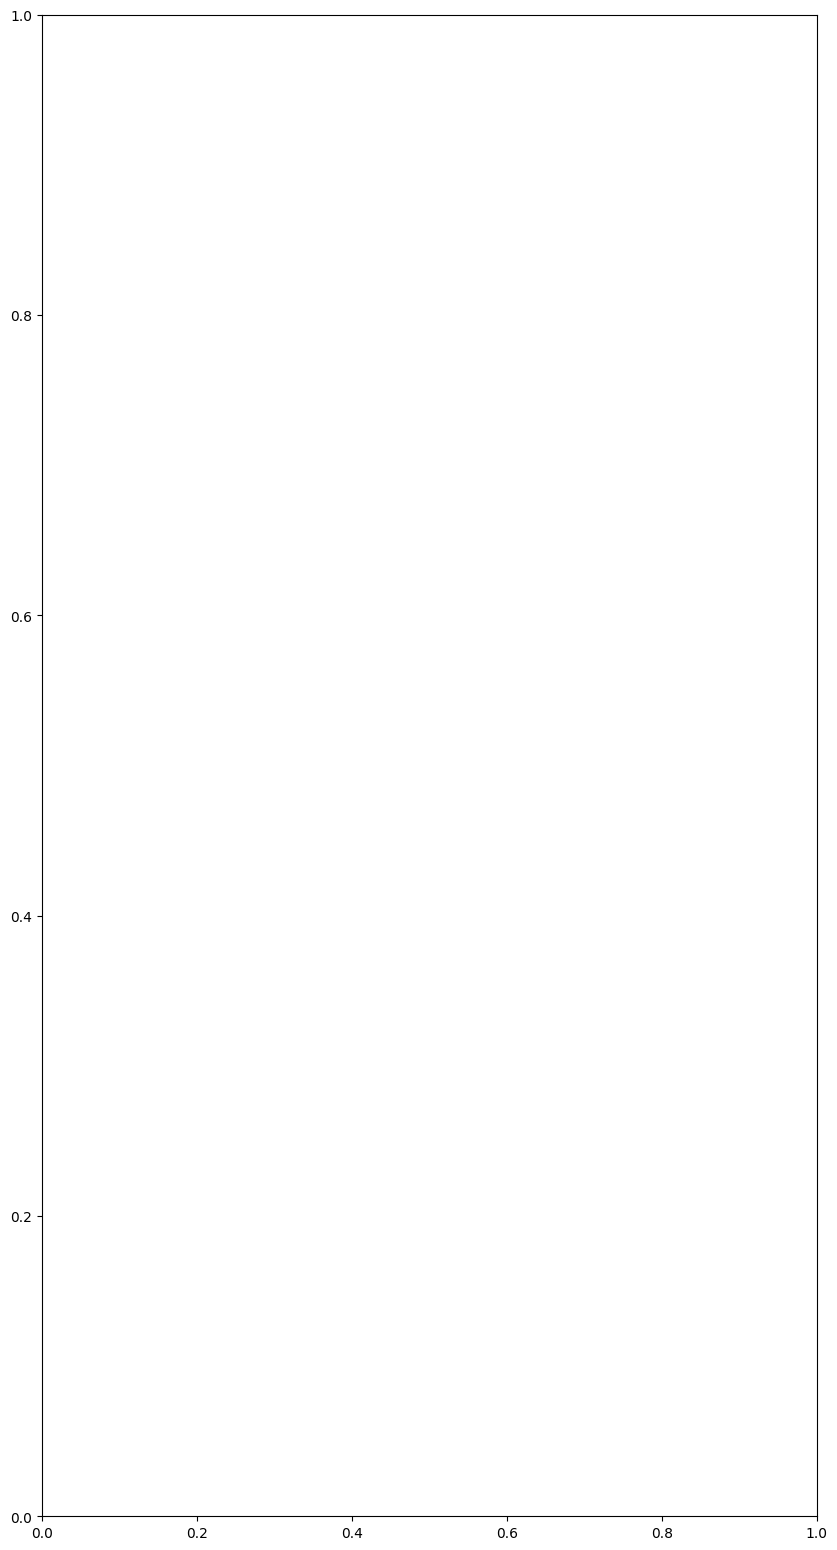

In [304]:
ai_response = client.invoke(human_msg)
response = execute_pandas_code(ai_response.content)

# Access the results
result_df = response["final_response"]["response_content"]
summary = response["final_response"].get("summary", "No summary provided.")
plot_path = response["final_response"].get("plot_path", "No plot generated.")

# Print or use them
print('+++++++++++++++++++++++++++++++')
print("result_df:\n",result_df)
print('++++++++++++++++++++++++++++++++')
print("Summary:\n", summary)
print('+++++++++++++++++++++++++++')
print("Plot saved at:", plot_path)


In [305]:
df.head()

,Cg_Normalized_Vendor,PO_L1,PO_L2,PO_L3,PO_L4,G/L Acct Long Text,Company Code,Region,Document number,Purchasing Document,Posting Date,Payment terms,Payment term No. of Days,Payment term Own Explanation,Spend
0,ABBOTT,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Supplies Lab Materials,1011,DE,6111959462,4400642682,2025-02-20,T105,10.0,"10 days 1.5%, net 30",237674.75
1,ABBOTT,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Supplies Lab Materials,1011,DE,6111975859,4400642682,2025-03-06,T105,10.0,"10 days 1.5%, net 30",211321.63
2,ABBOTT,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Supplies Lab Materials,1011,DE,6111902324,4400642682,2025-01-06,T105,10.0,"10 days 1.5%, net 30",200296.33
3,ABBOTT,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Trade Creditors GR/IR (Auto),2015,US,6111986007,4400729343,2025-03-13,T045,45.0,Net 45 Days,166367.98
4,ABBOTT,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Cleaning Equipment and Supplies,Supplies Lab Materials,1011,DE,6111974549,4400642682,2025-03-05,T105,10.0,"10 days 1.5%, net 30",9290.59


In [310]:
df['Company Code'].unique()

array([1011, 2015, 1095, 2012, 2010, 619, 4015, 606, 605, 603, 3075, 302,
       1010, 1040, 3065, 1080, 1070, 618, 3085, 4020, 1017, '3030-APAC',
       3010, 1023, 1094, 115, 1012, 620, 4030, 2016, 1098, 1026, 1030,
       1060, 150, 1050, 4025, 1020, 625], dtype=object)

In [306]:
ai_response = client.invoke(human_msg)
ai_response

AIMessage(content="```python\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Assuming df is the DataFrame already loaded with the provided structure\n\n# Grouping the data by 'Company Code' and summing the 'Spend'\nresult_df = df.groupby('Company Code')['Spend'].sum().reset_index()\n\n# Sorting the result by Spend in descending order for better visualization\nresult_df = result_df.sort_values(by='Spend', ascending=False)\n\n# Generating a summary text\nsummary_text = f'The report shows the total spend by company code. The total spend for each company code is calculated, with the highest spend appearing at the top.'\n\n# Plotting the results\nplt.figure(figsize=(10, len(result_df) * 0.5))  # Adjusting plot size based on the number of data points\nplt.bar(result_df['Company Code'], result_df['Spend'], color='blue')\nplt.xlabel('Company Code')\nplt.ylabel('Total Spend')\nplt.title('Total Spend by Company Code')\nplt.xticks(rotation=45)\nplt.tight_layout()\n\n# Saving the plot\n



Clean Code:
 import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is the DataFrame already loaded with the provided structure

# Grouping the data by 'Company Code' and summing the 'Spend'
result_df = df.groupby('Company Code')['Spend'].sum().reset_index()

# Sorting the result by Spend in descending order for better visualization
result_df = result_df.sort_values(by='Spend', ascending=False)

# Generating a summary text
summary_text = f'The report shows the total spend by company code. The total spend for each company code is calculated, with the highest spend appearing at the top.'

# Plotting the results
plt.figure(figsize=(10, len(result_df) * 0.5))  # Adjusting plot size based on the number of data points
plt.bar(result_df['Company Code'], result_df['Spend'], color='blue')
plt.xlabel('Company Code')
plt.ylabel('Total Spend')
plt.title('Total Spend by Company Code')
plt.xticks(rotation=45)
plt.tight_layout()

# Saving the plot
plt.savefig('top_vendors_plot.png')

# 

{'final_response': {'is_pandas_code': False,
  'pandas_code': None,
  'response_content': 'An error occurred: the dtypes of parameters x (object) and width (float64) are incompatible',
  'summary': None,
  'plot_path': None}}

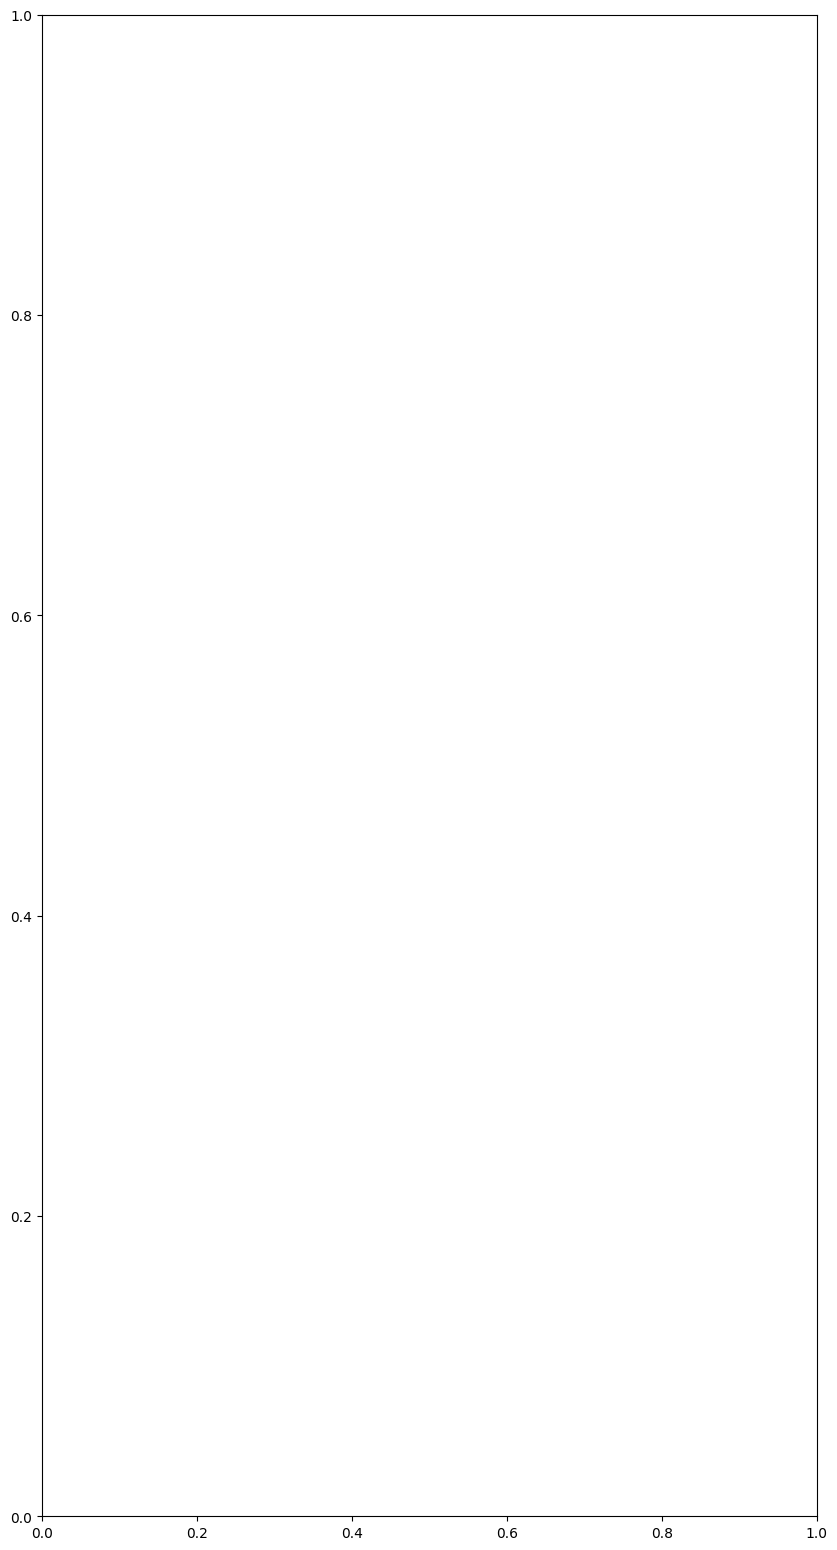

In [307]:
response = execute_pandas_code(ai_response.content)
response


In [308]:
response["final_response"]["response_content"]

'An error occurred: the dtypes of parameters x (object) and width (float64) are incompatible'